In [1]:
import sys
import json
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
import time

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2026-01-29 14:12:02.383514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-29 14:12:02.421239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-29 14:12:03.352084: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(f"🐍 Version Python : {sys.version.split()[0]}")
print(f"🤖 Version TensorFlow : {tf.__version__}")

try:
    print("\n--- État Système (nvidia-smi) ---")
    !nvidia-smi
except:
    print("Commande nvidia-smi non disponible (ce n'est pas grave sous Windows natif)")

print("\n--- Détection TensorFlow ---")
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("❌ Aucun GPU détecté par TensorFlow.")
    print("Causes possibles :")
    print("1. Vous n'avez pas installé 'tensorflow[and-cuda]'")
    print("2. Votre version de Python (3.13) n'est pas supportée.")
    print("3. La variable CUDA_VISIBLE_DEVICES = -1 est restée active.")
else:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU configuré : Mémoire dynamique activée")
    except RuntimeError as e:
        print(f"Erreur config GPU : {e}")

🐍 Version Python : 3.10.19
🤖 Version TensorFlow : 2.20.0

--- État Système (nvidia-smi) ---
Thu Jan 29 14:12:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0             15W /   80W |    3382MiB /   8188MiB |      0%      Default |
|                                         |     

In [3]:
MODEL_NAME = "model_dog_from_efficientnetb0"
CHECKPOINT_NAME = f"{MODEL_NAME}_checkpoint.keras"
FINAL_MODEL_NAME = f"{MODEL_NAME}_final.keras"

# Dossier d'images d'entraînement au format .jpg
path_train_dataset = '../dataset/Dog-Breed-Identification/train'
# Dossier d'images de test au format .jpg
path_test_dataset = '../dataset/Dog-Breed-Identification/test'
# Fichier des labels / classes au format .csv
path_features = '../dataset/Dog-Breed-Identification/labels.csv'
images_train_dataset = os.listdir(path_train_dataset)
images_test_dataset = os.listdir(path_test_dataset)


labels_df = pd.read_csv(path_features)
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
print(' No# of train images in data:', len(images_train_dataset))
print(' No# of test images in data:', len(images_test_dataset))

 No# of train images in data: 10222
 No# of test images in data: 10357


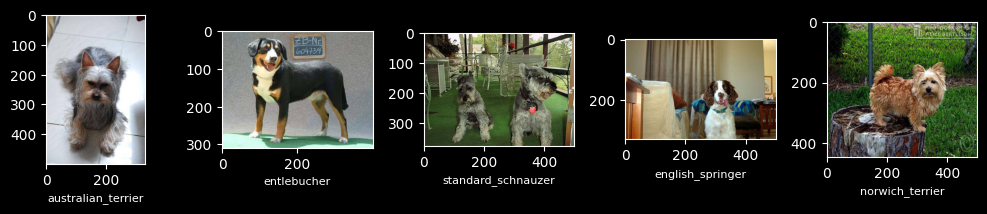

In [5]:
plt.figure(figsize=(10, 10))

# On boucle sur les 5 premières images
for i in range(5):
    plt.subplot(5, 5, i + 1)

    # 1. Récupérer le nom du fichier
    filename = images_train_dataset[i]

    # 2. Construire le chemin complet vers l'image
    img_path = os.path.join(path_train_dataset, filename)

    # 3. Charger l'image réelle (les pixels)
    img = mpimg.imread(img_path)

    # 4. Afficher l'image
    plt.imshow(img)

    # 5. Récupérer le label correct
    img_id = filename.split('.')[0]

    # On cherche la ligne dans le DataFrame où 'id' correspond à notre image
    try:
        label = labels_df.loc[labels_df['id'] == img_id, 'breed'].values[0]
    except IndexError:
        label = "Inconnu"

    plt.xlabel(label, fontsize=8)

plt.tight_layout()
plt.show()

In [6]:
batch_size = 32
seed = 42
shuffle = True

# Reconstitution des noms des fchiers d'images
labels_df['id'] = labels_df['id'].apply(lambda x: x + ".jpg")
print(labels_df.head())

# Création du générateur avec augmentation de données
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# Configuration pour l'entraînement avec uugmentation de données
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1. / 255,       # Normalisation des pixels entre 0 et 1
    validation_split=0.2,   # 20% des données serviront à la validation
    rotation_range=40,      # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2, # Décalage vertical
    horizontal_flip=True,
    fill_mode="nearest"
)

# Configuration pour la validation
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1. / 255,
    validation_split=0.2
)

# Entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=path_train_dataset,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=path_train_dataset,
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(224, 224)
)

                                     id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever
Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [7]:
print(train_generator.class_indices)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

In [8]:
# Couche de sortie : 120 neurones (un par race) + "softmax" pour un résultat entre 0 et 1
num_classes = len(train_generator.class_indices)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler" le modèle de base
base_model.trainable = False

# headerde classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Vérification de la structure
# model.summary()

I0000 00:00:1769692325.404711  156973 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2788 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(f"models/{MODEL_NAME}/checkpoints/{CHECKPOINT_NAME}",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Stop l'apprentissage
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

callbacks_list = [checkpoint, early_stop]

In [10]:
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks_list
)

Epoch 1/50


2026-01-29 14:12:09.160343: I external/local_xla/xla/service/service.cc:163] XLA service 0x73fb8814da90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-29 14:12:09.160357: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-29 14:12:09.214588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-29 14:12:09.678120: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-01-29 14:12:09.799686: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-29 14:12:10.

110/256 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.1203 - loss: 4.4287

2026-01-29 14:12:42.177165: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-29 14:12:42.262260: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2263 - loss: 3.6351

2026-01-29 14:13:20.832226: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-29 14:13:20.917377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from None to 0.65068, saving model to models/model_dog_from_efficientnetb0/checkpoints/model_dog_from_efficientnetb0_checkpoint.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 258ms/step - accuracy: 0.3693 - loss: 2.6746 - val_accuracy: 0.6507 - val_loss: 1.2813
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5979 - loss: 1.4528
Epoch 2: val_accuracy improved from 0.65068 to 0.69276, saving model to models/model_dog_from_efficientnetb0/checkpoints/model_dog_from_efficientnetb0_checkpoint.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 195ms/step - accuracy: 0.6021 - loss: 1.4300 - val_accuracy: 0.6928 - val_loss: 1.0725
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6562 - loss: 1.2082
Epoch 3: val_accuracy improved from 0.69276 to 0.69374, saving model to models/model_dog_from_efficientnetb0/checkpoints/model_dog_from_efficientnetb0_checkpoint.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.6514 - loss: 1.2138 - va

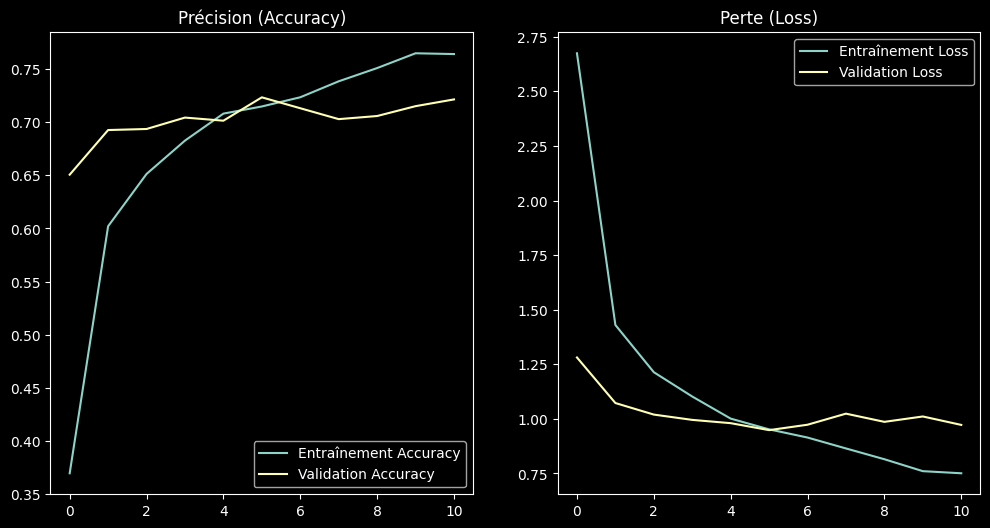

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Précision (Accuracy)')

# Courbe de Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Perte (Loss)')
plt.show()

In [12]:
# Sauvegarde au format moderne de Keras
model.save(f"models/{MODEL_NAME}/{FINAL_MODEL_NAME}")
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


2026-01-29 14:21:45.355181: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-29 14:21:45.437726: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


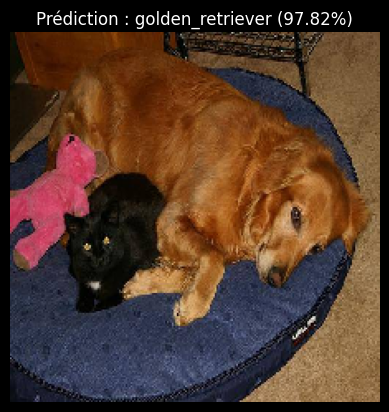

In [13]:
# 1. Créer le dictionnaire inversé (Index -> Nom de race)
labels_map = {v: k for k, v in train_generator.class_indices.items()}


def predict_breed(img_path):
    # Charger l'image et la redimensionner comme à l'entraînement (224x224)
    img = image.load_img(img_path, target_size=(224, 224))

    # Convertir en tableau de nombres (array)
    img_array = image.img_to_array(img)

    # Normaliser (diviser par 255 comme lors de l'entraînement)
    img_array = img_array / 255.0

    # Ajouter une dimension pour simuler un batch de 1 image (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Faire la prédiction
    predictions = model.predict(img_array)

    # Trouver l'index de la probabilité la plus élevée
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    predicted_breed = labels_map[predicted_class_index]

    # Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction : {predicted_breed} ({confidence:.2f}%)")
    plt.show()


# --- UTILISATION ---
# Remplacez par le chemin d'une image de votre dossier de test
test_image_path = os.path.join(path_test_dataset, os.listdir(path_test_dataset)[111])
predict_breed(test_image_path)

In [ ]:
# 1. Configuration Mémoire (Toujours indispensable sur RTX 4000)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 2. Activer Mixed Precision (Boost énorme sur RTX 4060)
mixed_precision.set_global_policy('mixed_float16')


# --- FONCTION DE TEST ---
def benchmark(device_name, steps=10):
    print(f"\n--- Test sur {device_name} en cours... ---")
    with tf.device(device_name):
        # Création d'un modèle factice
        model = EfficientNetB0(weights=None, input_shape=(224, 224, 3), classes=120)
        model.compile(optimizer='adam', loss='categorical_crossentropy')

        # Données factices (plus rapide que de charger depuis le disque)
        import numpy as np
        fake_data = np.random.random((16, 224, 224, 3)).astype('float32')
        fake_labels = np.random.random((16, 120)).astype('float32')

        # Chauffe (Warm-up)
        model.train_on_batch(fake_data, fake_labels)

        # Mesure
        start = time.time()
        for _ in range(steps):
            model.train_on_batch(fake_data, fake_labels)
        end = time.time()

        avg_time = (end - start) / steps
        print(f"⏱️ Temps moyen par batch : {avg_time * 1000:.1f} ms")
        return avg_time


# --- RÉSULTATS ---
t_cpu = benchmark('/CPU:0')
t_gpu = benchmark('/GPU:0')

print(f"\n🚀 ACCÉLÉRATION : Le GPU est {t_cpu / t_gpu:.1f}x plus rapide que le CPU !")


--- Test sur /CPU:0 en cours... ---


2026-01-29 14:21:56.597693: I external/local_xla/xla/service/service.cc:163] XLA service 0x28718ba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-29 14:21:56.597714: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version


⏱️ Temps moyen par batch : 1572.9 ms

--- Test sur /GPU:0 en cours... ---


In [ ]:
# Récupérer le mapping (ex: {'beagle': 0, 'boxer': 1})
class_indices = train_generator.class_indices

# Inverser pour avoir {0: 'beagle', 1: 'boxer'}
idx_to_class = {v: k for k, v in class_indices.items()}

# Sauvegarder dans un fichier
with open('class_indices.json', 'w') as f:
    json.dump(idx_to_class, f)

print("✅ Fichier class_indices.json généré !")